# MLP Double lesion Test

In [1]:
MODEL_TAG = 'FASHION+DROPOUT'
MODE = 'LOAD'
WITH_ONE_WAY_RANDOM_DEMO = False

In [2]:
# Parameters
MODEL_TAG = "FASHION"


In [3]:
assert MODE in ('STORE', 'LOAD')

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append('..')

import pickle

from IPython import display
from tqdm import tqdm
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd

from src.pointers import DATA_PATHS
from src.experiment_tagging import get_model_path
from src.lesion import (perform_lesion_experiment,
                              report_lesion_test)
from src.visualization import (run_double_spectral_cluster, draw_mlp_clustering_report,
                               build_weighted_dist_mat, plot_weighted_dist_mat,
                               draw_ow_weight_dependency_graph)

sns.set(style='whitegrid')

In [6]:
DATASET_NAME, *_ = MODEL_TAG.split('+')
DATASET_NAME = DATASET_NAME.lower()

PICKLE_PATH = f'../results/double-lesion-f{MODEL_TAG}.pickle'

In [7]:
if MODE == 'LOAD':
    with open(PICKLE_PATH, 'rb') as f:
        (N_CLUSTERS, single_df,
         TWO_WAY_N_SHUFFLES, TWO_WAY_PVALUE_THRESHOLD,
         double_joint_df, joint_metadata, 
         double_conditional_df, conditional_metadata) = pickle.load(f)
        
if MODE == 'STORE':
    N_CLUSTERS = 10
    TWO_WAY_N_SHUFFLES = 50
    TWO_WAY_PVALUE_THRESHOLD = 1 / TWO_WAY_N_SHUFFLES

## Clustering

CPU times: user 1min 3s, sys: 1min 25s, total: 2min 29s
Wall time: 24 s


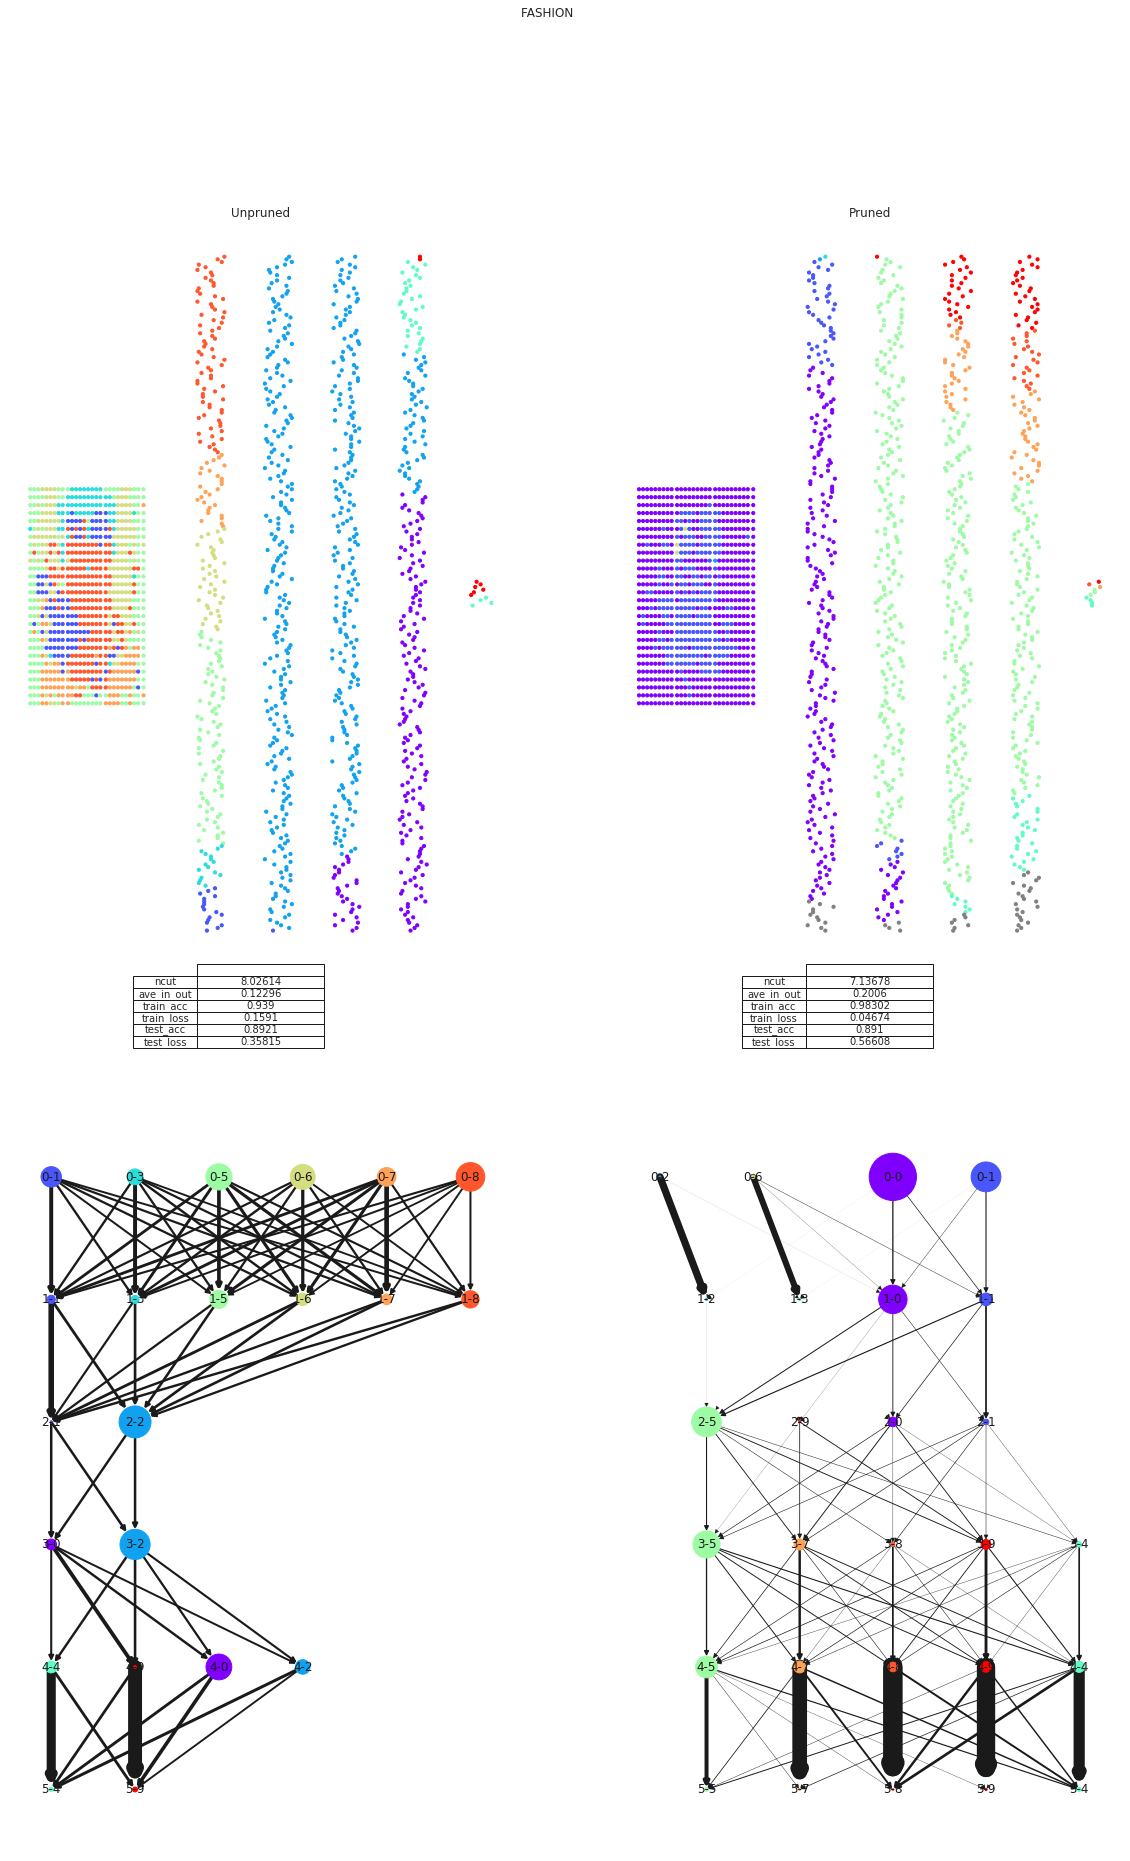

In [8]:
%%time

model_path = get_model_path(MODEL_TAG)
one_way_clustering_result = run_double_spectral_cluster(model_path, n_clusters=N_CLUSTERS, with_shuffle=False)

draw_mlp_clustering_report(model_path,
                           one_way_clustering_result,
                           n_cluster=N_CLUSTERS, title=f'{MODEL_TAG}')

## Single: Taxonomy of layer-clusters

In [9]:
%%time

model_path = get_model_path(MODEL_TAG)
if MODE == 'STORE':
    single_df = report_lesion_test(MODEL_TAG,
                                     '.' + DATA_PATHS[DATASET_NAME],
                                     model_path,
                                     n_clusters=N_CLUSTERS, n_shuffles=100, n_way=1,
                                     verbose=True)

CPU times: user 101 µs, sys: 128 µs, total: 229 µs
Wall time: 237 µs


In [10]:
single_df

diff  corrected_pvalue  label_in_layer_proportion    true  \
layer label                                                                
1     0     -0.0562          0.009901                   0.141079  0.8390   
      1     -0.1108          0.059406                   0.307054  0.7844   
      2     -0.2359          0.128713                   0.522822  0.6593   
      6      0.0000          0.633663                   0.004149  0.8952   
      7     -0.0013          0.881188                   0.024896  0.8939   
2     0      0.0001          0.732673                   0.003984  0.8953   
      1     -0.0002          0.643564                   0.011952  0.8950   
      2     -0.0004          0.554455                   0.007968  0.8948   
      6      0.0000          0.693069                   0.003984  0.8952   
      7     -0.7139          0.851485                   0.972112  0.1813   
3     3     -0.0167          0.009901                   0.115538  0.8785   
      4     -0.0003          0.722772                   0.035857  0.8949   
      5     -0.0102          0.009901                   0.083665  0.8850   
      6     -0.0121          0.009901                   0.111554  0.8831   
      7     -0.1452          0.019802                   0.529880  0.7500   
      8     -0.0086          0.019802                   0.067729  0.8866   
      9     -0.0024          0.237624                   0.055777  0.8928   
4     3     -0.2654          0.009901                   0.122881  0.6298   
      4     -0.0486          0.009901                   0.156780  0.8466   
      5     -0.3859          0.009901                   0.165254  0.5093   
      6     -0.1839          0.009901                   0.135593  0.7113   
      7      0.0004          1.000000                   0.207627  0.8956   
      8     -0.2454          0.009901                   0.122881  0.6498   
      9     -0.3245          0.009901                   0.088983  0.5707   

                 taxonomy      mean       std     z_score  n_layer_label  
layer label                                                               
1     0         important  0.871367  0.006230   -5.195194             34  
      1      diff-but-sig  0.825516  0.018082   -2.273809             74  
      2      diff-but-sig  0.718516  0.042661   -1.388071            126  
      6             small  0.894727  0.000763    0.620232              1  
      7             small  0.891419  0.002690    0.922240              6  
2     0             small  0.894887  0.000598    0.690145              1  
      1             small  0.894414  0.001056    0.554819              3  
      2             small  0.894600  0.000965    0.207312              2  
      6             small  0.894928  0.000476    0.571804              1  
      7      diff-but-sig  0.151845  0.031168    0.945046            244  
3     3         important  0.891042  0.003030   -4.139423             29  
      4             small  0.893872  0.001553    0.661733              9  
      5         important  0.892641  0.002086   -3.662763             21  
      6         important  0.891651  0.002360   -3.622978             28  
      7      diff-but-sig  0.841341  0.026871   -3.399266            133  
      8             other  0.893079  0.001831   -3.538278             17  
      9             other  0.893784  0.001480   -0.664827             14  
4     3         important  0.892690  0.001997 -131.659621             29  
      4         important  0.891765  0.002600  -17.373912             37  
      5         important  0.890992  0.003267 -116.843738             39  
      6         important  0.891611  0.002716  -66.379852             32  
      7          prunable  0.888659  0.005362    1.294391             49  
      8         important  0.892637  0.002193 -110.744713             29  
      9         important  0.893253  0.001895 -170.251549             21

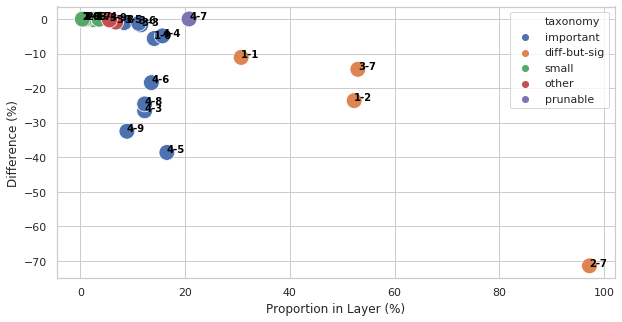

In [11]:
from src.lesion.output import plot_cluster_scatter

plot_cluster_scatter(single_df);

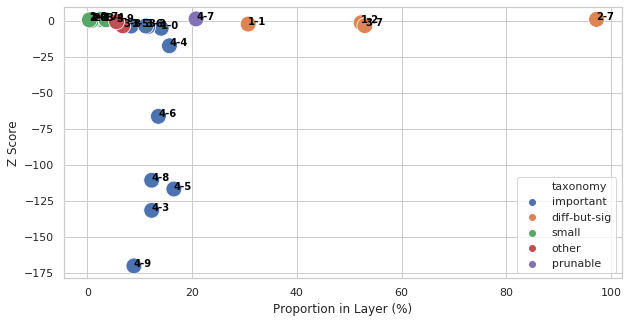

In [12]:
plot_cluster_scatter(single_df, y='z_score');

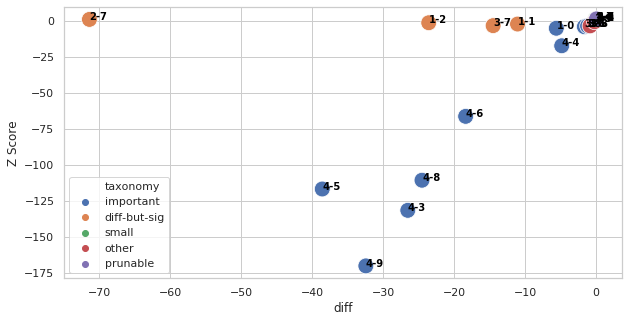

In [13]:
plot_cluster_scatter(single_df, x='diff', y='z_score');

#### Let's look on a random clustering

In [14]:
if WITH_ONE_WAY_RANDOM_DEMO:
    ax = plot_cluster_scatter(report_lesion_test(MODEL_TAG,
                                             '.' + DATA_PATHS[DATASET_NAME],
                                             model_path,
                                             n_clusters=N_CLUSTERS, n_shuffles=100, n_way=1,
                                             with_overall_plot=False, with_accuracy_profile=False,
                                             true_as_random=True,
                                             verbose=False),
                        vmin=-13)

    ax.set_ylim(-13, 1);

## Double: Exploring Dependencies between layer-clusters

In [15]:
from src.lesion.output import (build_double_mat,
                                     build_double_joint_interaction_mat,
                                     build_conditional_double_df,
                                     plot_double_heatmap,
                                     compute_damaged_cluster_stats,
                                     enrich_score_double_conditional_df)

In [16]:
if MODE == 'STORE':

    (joint_true_results,
     joint_all_random_results,
     joint_metadata,
     joint_evaluation) = perform_lesion_experiment('.' + DATA_PATHS[DATASET_NAME],
                                                   model_path,
                                                   n_clusters=N_CLUSTERS,
                                                   n_shuffles=TWO_WAY_N_SHUFFLES,
                                                   n_way=2,
                                                   n_way_type='joint',
                                                   with_random=True,
                                                   verbose=True)



In [17]:
from src.lesion.output import compute_damaged_cluster_stats

In [18]:
if MODE == 'STORE':
    double_joint_df = compute_damaged_cluster_stats(joint_true_results, joint_all_random_results,
                                                     joint_metadata, joint_evaluation)

double_joint_df.head()

value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score
labels_in_layers,,,,,,,
"((1, 0), (1, 0))",-0.0562,0.019608,0.8390,important,0.871386,0.006338,-5.109505
"((1, 0), (1, 1))",-0.2355,0.019608,0.6597,important,0.768108,0.035641,-3.041667
"((1, 0), (1, 2))",-0.4030,0.058824,0.4922,diff-but-sig,0.620898,0.058522,-2.199132
"((1, 0), (1, 6))",-0.0562,0.019608,0.8390,important,0.870614,0.006279,-5.035199
"((1, 0), (1, 7))",-0.0705,0.019608,0.8247,important,0.866296,0.007438,-5.592538


#### $Diff_{ij}$

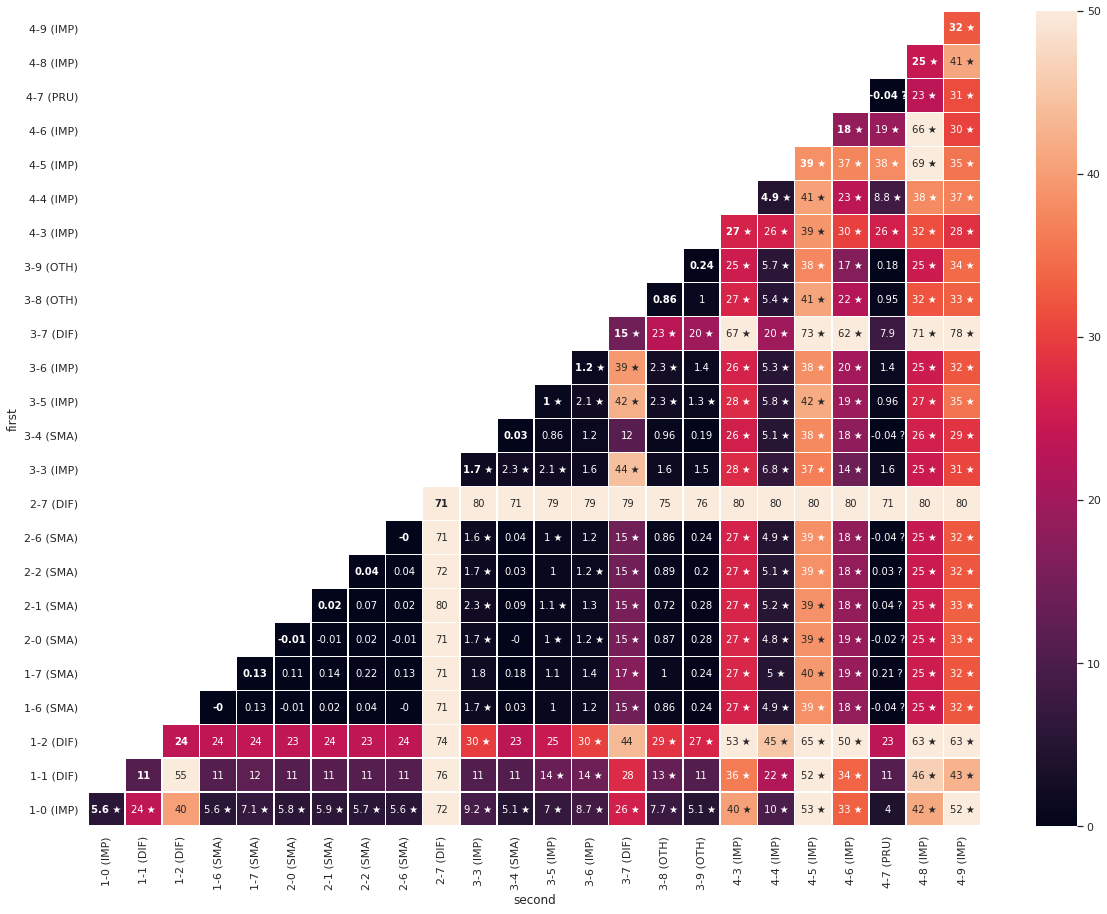

In [19]:
double_joint_diff_mat = -build_double_mat(double_joint_df, single_df, col='diff')

plot_double_heatmap(double_joint_diff_mat, double_joint_df,
                     metadata=joint_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50);

### Joint

#### What can we learn from the joint TWBD?

Using the single TWBD prior, with created a taxonomy of clusters, we get the primary division is to important (diff > 1 and significant) and not-important. Let's use this dichotomy to analyze the joint TWBD.

Let's look at layer-cluster X and Y. If we assume that they are both important (as single), we won't be surprised that the joint damaged XY is also important(diff > 1 and significant). Therefore, we should focus on XY if it is not important.

If we assume that X and Y are both *not* important, it would be interesting if the joint damage XY is important. It means that only their combined formation together is impactful.

Finally, considering the case for X is important, and Y is not (without loss of generality), our prior would be that the joint damaged XY will also be important, because of the contribution of X. So not important XY matters in that situation.

To summary up, these are the cases we care about, because they convey information that changes our single TWBD prior:

| X | Y | XY |
|---|---|----|
| ✔️ | ✔️ | ❌  |
| ✔️ | ❌ | ❌  |
| ❌ | ❌ | ✔️  |

In [20]:
from src.lesion.output import build_double_joint_imp_grouped_df

double_joint_imp_df, double_joint_imp_grouped_df = build_double_joint_imp_grouped_df(double_joint_df, single_df)

double_joint_imp_grouped_df

first_is_important  second_is_important  is_important
❌                   ❌                    ❌               93
                    ✔️                   ✔️              88
✔️                  ✔️                   ✔️              54
                    ❌                    ✔️              22
❌                   ✔️                   ❌               21
                    ❌                    ✔️              12
✔️                  ❌                    ❌                9
                    ✔️                   ❌                1
dtype: int64

##### Let's iterate on the interesting cases:

We should be REALLY CAREFUL when we look at double damage when both of the clusters come from the same layer. The space of possible shuffles behaves different, so I won't try to come up with observation in these cases.

In [21]:
from collections import Counter

double_joint_interesting_cases = [('✔️', '✔️', '❌'),
                              ('✔️', '❌', '❌'),
                              ('❌', '✔️', '❌'),
                              ('❌', '❌', '✔️')]

is_important_fields = ['first_is_important', 'second_is_important', 'is_important'] 

In [22]:
for interesting_case in double_joint_interesting_cases:
    
    intresting_double_joint_imp_df = (double_joint_imp_df[(double_joint_imp_df[is_important_fields]
                                                   == interesting_case)
                                              .all(axis=1)])

    # same cluster-layer is an anomaly that we should remove (we do so with the heatmap plotting)
    intresting_double_joint_imp_df = intresting_double_joint_imp_df[intresting_double_joint_imp_df['first']
                                                            != intresting_double_joint_imp_df['second']]

    if not intresting_double_joint_imp_df.empty:
        
        print(interesting_case)

        display.display(intresting_double_joint_imp_df.sort_values('diff'))
        
        display.display(Counter(tuple(sorted(v))
                        for v in (intresting_double_joint_imp_df[['first_taxonomy', 'second_taxonomy']]).values))

('✔️', '✔️', '❌')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
198,"((3, 3), (3, 6))",-0.016,0.058824,0.8792,diff-but-sig,0.88594,0.004836,-1.393846,"(3, 3)","(3, 6)",important,important,❌,✔️,✔️


Counter({('important', 'important'): 1})

('✔️', '❌', '❌')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
9,"((1, 0), (2, 7))",-0.7153,0.862745,0.1799,diff-but-sig,0.147416,0.031895,1.018460,"(1, 0)","(2, 7)",important,diff-but-sig,❌,✔️,❌
2,"((1, 0), (1, 2))",-0.4030,0.058824,0.4922,diff-but-sig,0.620898,0.058522,-2.199132,"(1, 0)","(1, 2)",important,diff-but-sig,❌,✔️,❌
21,"((1, 0), (4, 7))",-0.0403,0.235294,0.8549,diff-but-sig,0.861432,0.011366,-0.574692,"(1, 0)","(4, 7)",important,prunable,❌,✔️,❌
206,"((3, 3), (4, 7))",-0.0162,0.196078,0.8790,diff-but-sig,0.882968,0.007823,-0.507229,"(3, 3)","(4, 7)",important,prunable,❌,✔️,❌
200,"((3, 3), (3, 8))",-0.0161,0.058824,0.8791,diff-but-sig,0.887952,0.003942,-2.245626,"(3, 3)","(3, 8)",important,other,❌,✔️,❌
201,"((3, 3), (3, 9))",-0.0154,0.039216,0.8798,diff-but-sig,0.889102,0.003504,-2.654753,"(3, 3)","(3, 9)",important,other,❌,✔️,❌
237,"((3, 6), (3, 9))",-0.0143,0.058824,0.8809,diff-but-sig,0.889122,0.003385,-2.428794,"(3, 6)","(3, 9)",important,other,❌,✔️,❌
242,"((3, 6), (4, 7))",-0.0136,0.254902,0.8816,diff-but-sig,0.883744,0.007230,-0.296526,"(3, 6)","(4, 7)",important,prunable,❌,✔️,❌
231,"((3, 5), (4, 7))",-0.0096,0.490196,0.8856,other,0.884270,0.006353,0.209345,"(3, 5)","(4, 7)",important,prunable,❌,✔️,❌


Counter({('diff-but-sig', 'important'): 2,
         ('important', 'prunable'): 4,
         ('important', 'other'): 3})

('❌', '✔️', '❌')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
181,"((2, 7), (3, 3))",-0.7952,0.098039,0.1000,diff-but-sig,0.145740,0.032428,-1.410505,"(2, 7)","(3, 3)",diff-but-sig,important,❌,❌,✔️
194,"((2, 7), (4, 9))",-0.7952,0.058824,0.1000,diff-but-sig,0.141624,0.029914,-1.391442,"(2, 7)","(4, 9)",diff-but-sig,important,❌,❌,✔️
193,"((2, 7), (4, 8))",-0.7952,0.078431,0.1000,diff-but-sig,0.151866,0.035873,-1.445837,"(2, 7)","(4, 8)",diff-but-sig,important,❌,❌,✔️
191,"((2, 7), (4, 6))",-0.7952,0.058824,0.1000,diff-but-sig,0.139118,0.029200,-1.339678,"(2, 7)","(4, 6)",diff-but-sig,important,❌,❌,✔️
190,"((2, 7), (4, 5))",-0.7952,0.058824,0.1000,diff-but-sig,0.137610,0.029572,-1.271796,"(2, 7)","(4, 5)",diff-but-sig,important,❌,❌,✔️
189,"((2, 7), (4, 4))",-0.7952,0.098039,0.1000,diff-but-sig,0.140686,0.040469,-1.005364,"(2, 7)","(4, 4)",diff-but-sig,important,❌,❌,✔️
188,"((2, 7), (4, 3))",-0.7952,0.078431,0.1000,diff-but-sig,0.144380,0.034549,-1.284569,"(2, 7)","(4, 3)",diff-but-sig,important,❌,❌,✔️
183,"((2, 7), (3, 5))",-0.7946,0.078431,0.1006,diff-but-sig,0.148928,0.037631,-1.284261,"(2, 7)","(3, 5)",diff-but-sig,important,❌,❌,✔️
184,"((2, 7), (3, 6))",-0.7903,0.098039,0.1049,diff-but-sig,0.145556,0.030982,-1.312264,"(2, 7)","(3, 6)",diff-but-sig,important,❌,❌,✔️
57,"((1, 2), (3, 5))",-0.2477,0.117647,0.6475,diff-but-sig,0.709532,0.043851,-1.414622,"(1, 2)","(3, 5)",diff-but-sig,important,❌,❌,✔️


Counter({('diff-but-sig', 'important'): 11, ('important', 'small'): 10})

('❌', '❌', '✔️')


value,labels_in_layers,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,first,second,first_taxonomy,second_taxonomy,is_important,first_is_important,second_is_important
60,"((1, 2), (3, 8))",-0.2874,0.019608,0.6078,important,0.713136,0.039112,-2.693219,"(1, 2)","(3, 8)",diff-but-sig,other,✔️,❌,❌
61,"((1, 2), (3, 9))",-0.2677,0.019608,0.6275,important,0.714912,0.039090,-2.236183,"(1, 2)","(3, 9)",diff-but-sig,other,✔️,❌,❌
246,"((3, 7), (3, 8))",-0.2287,0.019608,0.6665,important,0.819938,0.032965,-4.654557,"(3, 7)","(3, 8)",diff-but-sig,other,✔️,❌,❌
247,"((3, 7), (3, 9))",-0.1968,0.019608,0.6984,important,0.820944,0.032818,-3.734011,"(3, 7)","(3, 9)",diff-but-sig,other,✔️,❌,❌
100,"((1, 7), (3, 7))",-0.1688,0.019608,0.7264,important,0.837052,0.024879,-4.447563,"(1, 7)","(3, 7)",small,diff-but-sig,✔️,❌,❌
119,"((2, 0), (3, 7))",-0.1532,0.019608,0.7420,important,0.842100,0.025475,-3.929321,"(2, 0)","(3, 7)",small,diff-but-sig,✔️,❌,❌
137,"((2, 1), (3, 7))",-0.1528,0.019608,0.7424,important,0.840048,0.025987,-3.757522,"(2, 1)","(3, 7)",small,diff-but-sig,✔️,❌,❌
154,"((2, 2), (3, 7))",-0.1453,0.019608,0.7499,important,0.840602,0.026070,-3.479110,"(2, 2)","(3, 7)",small,diff-but-sig,✔️,❌,❌
80,"((1, 6), (3, 7))",-0.1452,0.019608,0.7500,important,0.841192,0.024879,-3.665412,"(1, 6)","(3, 7)",small,diff-but-sig,✔️,❌,❌
170,"((2, 6), (3, 7))",-0.1451,0.019608,0.7501,important,0.841532,0.024740,-3.695671,"(2, 6)","(3, 7)",small,diff-but-sig,✔️,❌,❌


Counter({('diff-but-sig', 'other'): 5, ('diff-but-sig', 'small'): 6})

It is hard to come up with a firm conclusions, but we can clearly see that in that pattern, "almost" important layer-cluster (diff-but-sig or sig-but-diff) is hitting the important criterion with the help of another layer-cluster.

One tempting interpretation, if we continue our previous line of reasoning until now, is that we found a higher-level clustering. These two layer-clusters should be grouped together. However, while the single BDT and its taxonomy are based on spectral clustering, and it is justified by the static structure (stronger weights inside a cluster compared to outside), this is not the case here.

An alternative explanation could be that we grouped with joint TWBDT two unrelated layer-clusters, so we did damage in two different "functions"; therefore, it a sign for a separate grouping. 


By the joint TWBDt experiment, we cannot distinguish the two possible explanations; therefore, we'll turn to another method to perform double BDT, which helps us to discover dependencies (in the sense of information flow) between layer-clusters).

### Conditional - $first|second$

* Difference - As in joint $Diff_{first,second}$
* P-value - Fix the *second* layer-cluster and shuffle the *first*

In [23]:
if MODE == 'STORE':
    (conditional_true_results,
     conditional_all_random_results,
     conditional_metadata,
     conditional_evaluation) = perform_lesion_experiment('.' + DATA_PATHS[DATASET_NAME],
                                                   model_path,
                                                   n_clusters=N_CLUSTERS,
                                                   n_shuffles=TWO_WAY_N_SHUFFLES,
                                                   n_way=2,
                                                   n_way_type='conditional',
                                                   with_random=True,
                                                   verbose=True)

In [24]:
if MODE == 'STORE':
    double_conditional_df = compute_damaged_cluster_stats(conditional_true_results,
                                                           conditional_all_random_results,
                                                           conditional_metadata,
                                                           conditional_evaluation,
                                                           double_joint_df=double_joint_df,
                                                           single_df=single_df,
                                                           diff_field='s_i|j')

    double_conditional_df = enrich_score_double_conditional_df(double_conditional_df, single_df)


double_conditional_df.head()

value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,s_i|j
labels_in_layers,,,,,,,,
"((1, 0), (1, 0))",-0.0562,0.019608,0.8390,important,0.871386,0.006338,-5.109505,-0.0562
"((1, 0), (1, 1))",-0.2355,0.039216,0.6597,diff-but-sig,0.737706,0.025538,-3.054457,-0.1247
"((1, 0), (1, 2))",-0.4030,0.019608,0.4922,important,0.586300,0.034591,-2.720334,-0.1671
"((1, 0), (1, 6))",-0.0562,0.039216,0.8390,diff-but-sig,0.870746,0.007733,-4.105152,-0.0562
"((1, 0), (1, 7))",-0.0705,0.019608,0.8247,important,0.867940,0.008151,-5.305100,-0.0692


Let's plot on heatmap the results:
* Rows: First ("shuffled") layer cluster
* Columns: Second ("fixed"/"conditioned") layer-cluster
* Cells: Difference of true layter-cluster (number) as well as significance (★)

Of course, the matrix will be symmetric concerning the difference; however, the significance won't be necessary symmetric.

The diagonal represents the single BDT. 

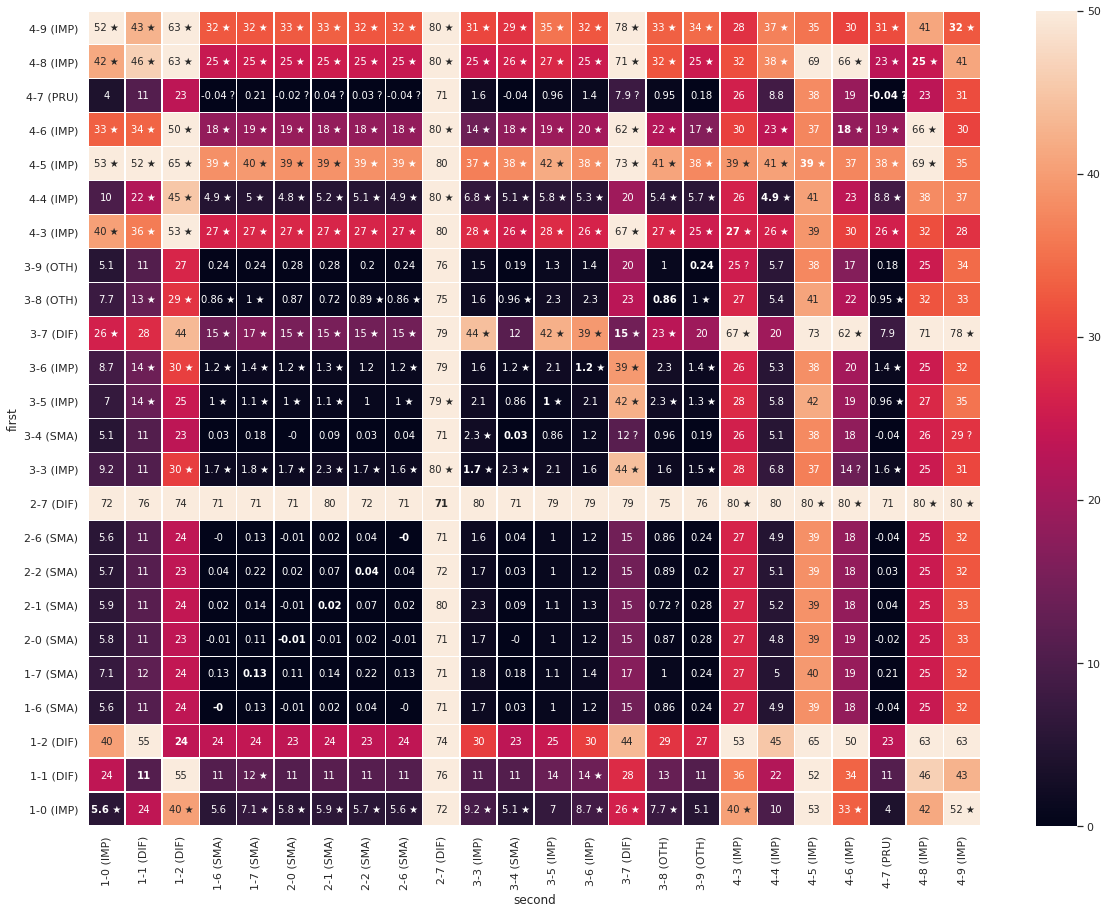

In [25]:
double_conditional_true_mat = -build_double_mat(double_conditional_df, single_df, col='diff')

plot_double_heatmap(double_conditional_true_mat, double_conditional_df, is_trig=False,
                     metadata=conditional_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50);

#### We can look also into the $s_{i|j}$ - which was used to define the taxonomy (see remark later):

## $s_{i|j} = Diff_{ij} - Diff_{j} = (Acc - Acc_{ij}) - (Acc - Acc_{j}) = Acc_{j} - Acc_{ij}$

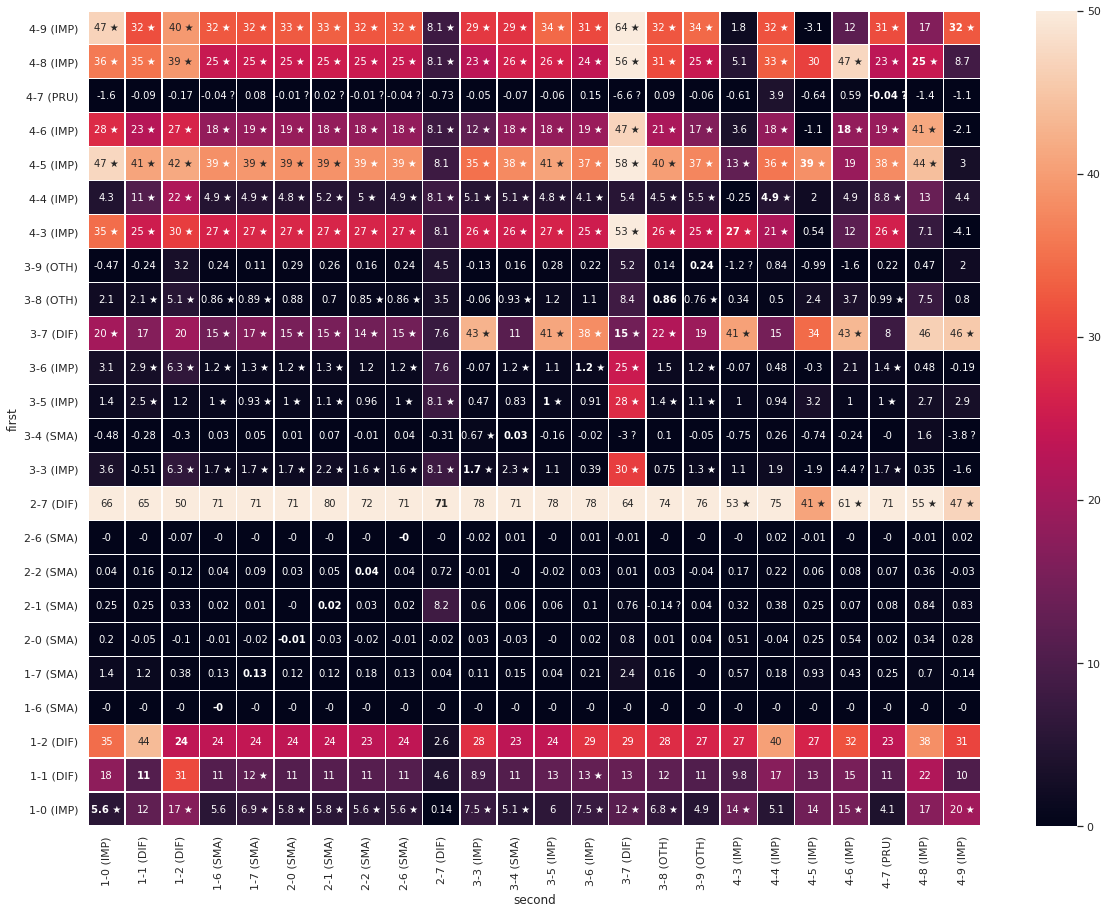

In [26]:
doublecond_sij_mat = -build_double_mat(double_conditional_df, single_df, col='s_i|j')

plot_double_heatmap(doublecond_sij_mat, double_conditional_df, is_trig=False,
                     metadata=conditional_metadata, pvalue_threshod=TWO_WAY_PVALUE_THRESHOLD,
                     vmax=50);

### Remark & TODO: Integrate into notebook, not as contra to `diff`

Let's look at the case of `X -> Y`, where both X and Y are *important* single layer-cluster.
If we damage Y, then the output of X won't have any impact.
So `d_Y ≈ d_XY` (or `s_X|Y ≈ 0`).
The opposite argument gives us `d_X ≈ d_XY` (or `s_Y|X ≈ 0`).

I defined an *important conditional* damage X|Y by these two necessary conditions:
1. `d_XY > 1%`
2. The p-value (damaging X while fixing Y) is minimal, i.e., `1 / (#shuffles + 1)`. In other words, `d_XY` is bigger than `d_ZY` for all (sampled) random shuffles of X (here Z).

Now, I'd argue that condition (1) indeed doesn't make sense, but (2) is totally fine.

First, the "importance" of a conditional damage `X|Y` should be defined in terms of `s_X|Y` and not `d_XY`. The latter is dependent on the impact of Y, which we would like to remove, while `s_X|Y` takes it into account. So a better first condition would be `s_X|Y > 1%`, i.e., the additional damage of X on top of Y is at least 1% of accuracy.

Second, recall that we are focusing on the case of `X -> Y`. Assume we damage Y. Damaging X won't increase the damage of Y ( `s_X|Y ≈ 0`), while any other random shuffle Z might contain other neurons that influence other neurons in the layer of Y.
**So, they will have a bigger difference, and we would have p-value equals to 1!**
However, all the four types of influence (such as `X -> Y`) are *idealized*, and X probably influences on other neurons in the layer of Y, so we introduce some noise to the calculated accuracy. Therefore, we won't get precisely one for p-value.
A prediction we can make here is that the standard deviation would be relatively small, and **we should check it**.

This line of argumentation works as well for the `Y|X` damage, and other types of `(X|Y, Y|X)` combinations.

#### We can also explore the relationship between `s_i|j` and `diff`. Keep in mind the taxonomy is based on `s_i|j`.

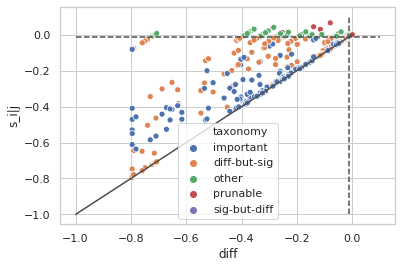

In [27]:
sns.scatterplot(x='diff', y='s_i|j', hue='taxonomy', data=double_conditional_df);
plt.plot([-1, 0], [-1, 0], ls='-', c='.3');
plt.plot([-0.01, -0.01], [-1, 0.1], ls='--', c='.3');
plt.plot([-1, 0.1], [-0.01, -0.01], ls='--', c='.3');

As we could expect, there is a linear relationship between the two metrics. The different "parallel" lines are probably coming from different layer-cluster we conditioned on them because it set the offset (because $diff_j$ is fixed.

#### Let's see if we get $s_{i|j}$ > 1% with p-value = 1 (called `least_important` in the taxonomy):

In [28]:
double_conditional_df['taxonomy'].value_counts()

other           225
important       193
diff-but-sig    136
prunable         12
sig-but-diff     10
Name: taxonomy, dtype: int64

In [29]:
double_conditional_df[double_conditional_df['taxonomy'] == 'least_important']

value,diff,corrected_pvalue,true,taxonomy,mean,std,z_score,s_i|j
labels_in_layers,,,,,,,,


### How can we use conditional TWBDT? Discovering Dependencies!

Suppose we have two layer-cluster $X$ and $Y$, where $X$ is in an earlier layer then $Y$. We will assume that both of them are *important* by the single BDT (diff. and sig.).

Let's focus only on *important* layer-clusters, because we know by the single BDT that they are important to the functioning of the network.

We will say that a layter-cluster $Y$ is *depended* on layer-cluster $X$ if there is a *flow of information* from $X$ to $Y$, i.e. the values of $X$ are required for computing $Y$. We will show it as:

$$X \rightarrow Y$$

(⚠️ We need a better formalization!)

#### There are four kind of possible (idealistic) dependencies, whether there are additional involved layer-clusters ($Z$ and $Z'$):

![](imgs/ctwbd-dependencies.jpg)

#### How will conditional TWBDT behave?
(keep in mind, both $X$ and $Y$ are important)

| Type | X\|Y | Y\|X | Why? |
|------|-----|-----|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| I | ❌ | ❌ | All the (information) output of X goes to Y, and all of the (information) input of Y comes from X. So they are tied together, and damage in one for them will be equivalent to damage the other one. |
| II | ✔️ | ❌ | Damaging X will block already all the input of Y, so no additional impact for damaging Y afterwords. However, Z gets input from X independently, so only conditioning on Y won't block all the information from X. |
| III | ❌ | ✔️ | The opposite argument from the previous row holds. |
| IV | ✔️ | ✔️ | Both of the two previous arguments hold. |

**We cannot learn anything from the last type IV**, because it will have the same behavior as no flow of information between $X$ and $Y$. Therefore, we care only about the first three types. It does make sense because, by our prior (single BDT), we should be "surprised" if a layer-cluster stops to be important.

In [30]:
from src.lesion.output import build_doublecond_imp_merged_df

doublecond_imp_df = build_doublecond_imp_merged_df(double_conditional_df, single_df)

In [31]:
doublecond_imp_df

value,sorted,X|Y,Y|X,s_X|Y,s_Y|X
0,"((1, 0), (3, 3))",True,False,-0.0751,-0.0356
1,"((1, 0), (3, 5))",False,False,-0.0598,-0.0138
2,"((1, 0), (3, 6))",True,False,-0.0753,-0.0312
3,"((1, 0), (4, 3))",True,True,-0.1372,-0.3464
4,"((1, 0), (4, 4))",False,False,-0.0510,-0.0434
5,"((1, 0), (4, 5))",False,True,-0.1443,-0.4740
6,"((1, 0), (4, 6))",True,True,-0.1494,-0.2771
7,"((1, 0), (4, 8))",False,True,-0.1704,-0.3596
8,"((1, 0), (4, 9))",True,True,-0.2004,-0.4687
9,"((3, 3), (4, 3))",False,True,-0.0114,-0.2601


This a count for every type:

In [32]:
doublecond_imp_df.groupby(['X|Y', 'Y|X']).size()

X|Y    Y|X  
False  False     2
       True     20
True   False     2
       True      3
dtype: int64

Let's see how $s_{i|j}$ is influnced by the type:

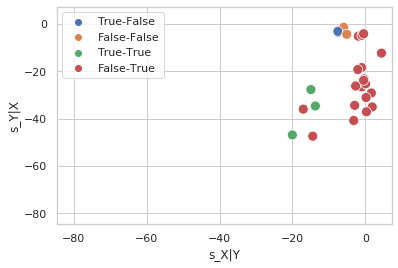

In [33]:
doublecond_imp_type = (doublecond_imp_df['X|Y'].astype(str) + '-' + doublecond_imp_df['Y|X'].astype(str)).values

ax = sns.scatterplot(doublecond_imp_df['s_X|Y']*100,
                     doublecond_imp_df['s_Y|X']*100,
                     hue=doublecond_imp_type,
                     s=100)

sij_min, sij_max = double_conditional_df['s_i|j'].min() * 100 - 5, double_conditional_df['s_i|j'].max() * 110

ax.axis([sij_min, sij_max, sij_min, sij_max]);

Let's take only Type I, II and II: There is at least one False for X|Y and Y|X:

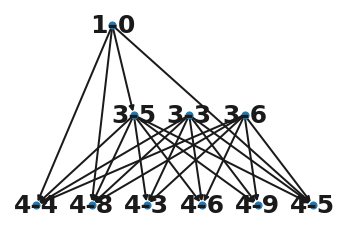

In [34]:
from src.lesion.output import draw_doublecond_dependency_graph

draw_doublecond_dependency_graph(doublecond_imp_df, single_df);

### For comparison, let's see the "dependency" graph by the strongest weight (absolute sum) path between two layers

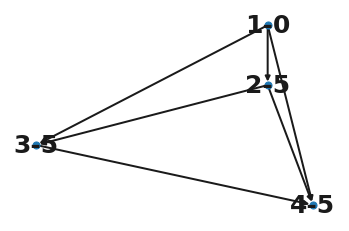

In [35]:
one_way_weighted_dist_mat = build_weighted_dist_mat(model_path, one_way_clustering_result)

draw_ow_weight_dependency_graph(one_way_weighted_dist_mat);

### Although the two graphs have shared edges, they are not the same, and they capture different stuff.

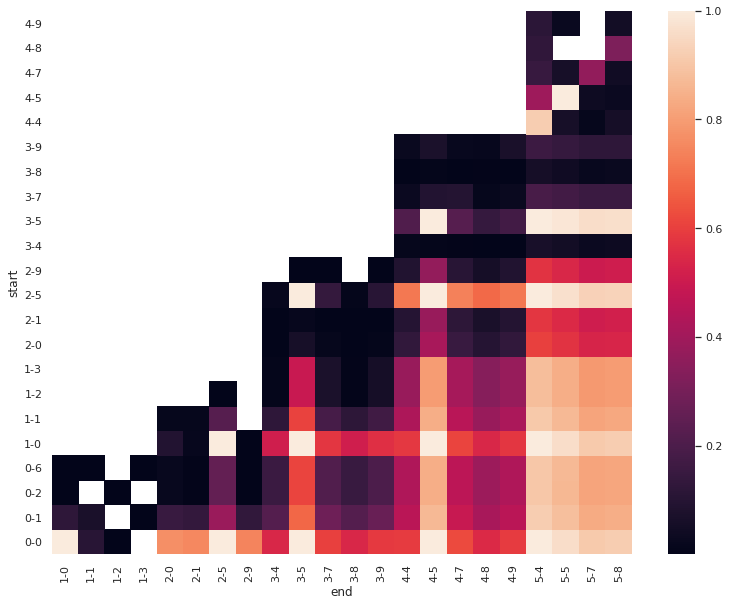

In [36]:
plot_weighted_dist_mat(one_way_weighted_dist_mat);

### IGNORE ME - IT IS MORE COMPLEX THAN IT SEEMS
### Validation: Transitivity

We can try to valdidate our dependency graph, by checking whether it is transitive:

#### If
$$
X \rightarrow Z \rightarrow Y
$$

### Then

$$
X \rightarrow Y
$$

### Store Data

In [37]:
if MODE == 'STORE':
    with open(PICKLE_PATH, 'wb') as f:
        pickle.dump((N_CLUSTERS, single_df,
                     TWO_WAY_N_SHUFFLES, TWO_WAY_PVALUE_THRESHOLD,
                     double_joint_df, joint_metadata,
                     double_conditional_df, conditional_metadata),
                   f)